In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import netCDF4 as nc

# !pip install matplotlib
import matplotlib.pyplot as plt

# !pip install xarray
import xarray as xr

# !pip install scipy
from  scipy import stats, signal #Required for detrending data and computing regression

### Introdução

[Referência para a implementação do trabalho](https://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html)



#### Links para os datasets
* [Precipition - Mean - Surface - Monthly](https://psl.noaa.gov/data/gridded/data.gpcp.html)
* [Air Temperature - Mean - Surface - Monthly](https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.html)


#### Reading datasets

In [3]:
DATA_DIR = "./data"

air = xr.open_dataset(f"{DATA_DIR}/air.sig995.mon.mean.nc")
air = air.air

### Preparing dataset

#### Monthly averaging

<AxesSubplot:xlabel='time'>

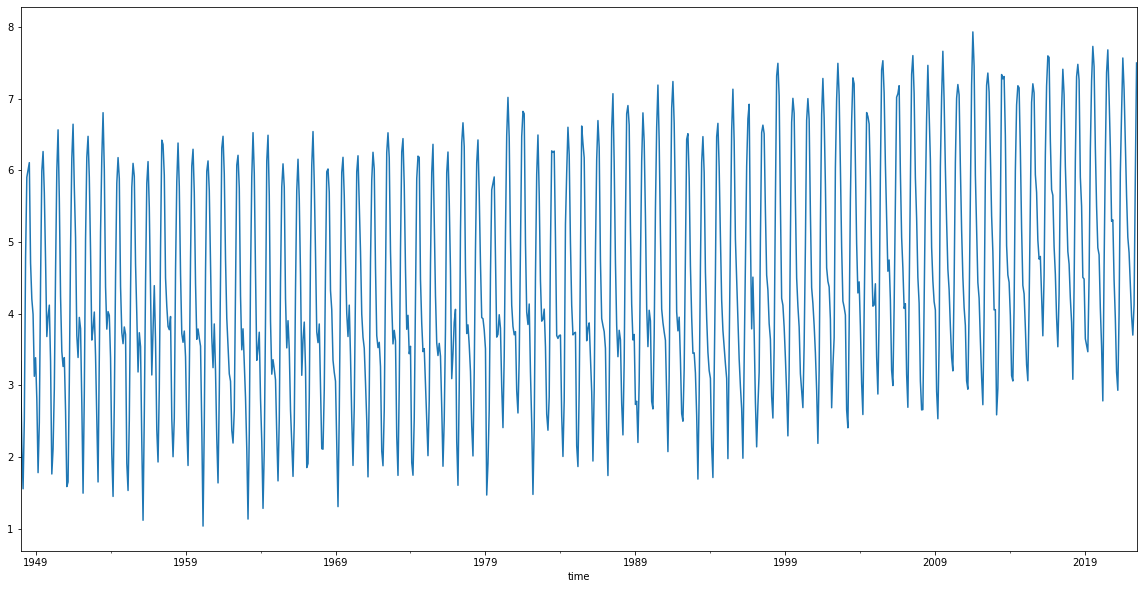

In [4]:
air.mean({'lat', 'lon'}).to_dataframe()['air'].plot(figsize=(20,10))

#### Calculate monthly anomalies
In climatology, “anomalies” refer to the difference between observations and typical weather for a particular season. Unlike observations, anomalies should not show any seasonal cycle.

<AxesSubplot:xlabel='time'>

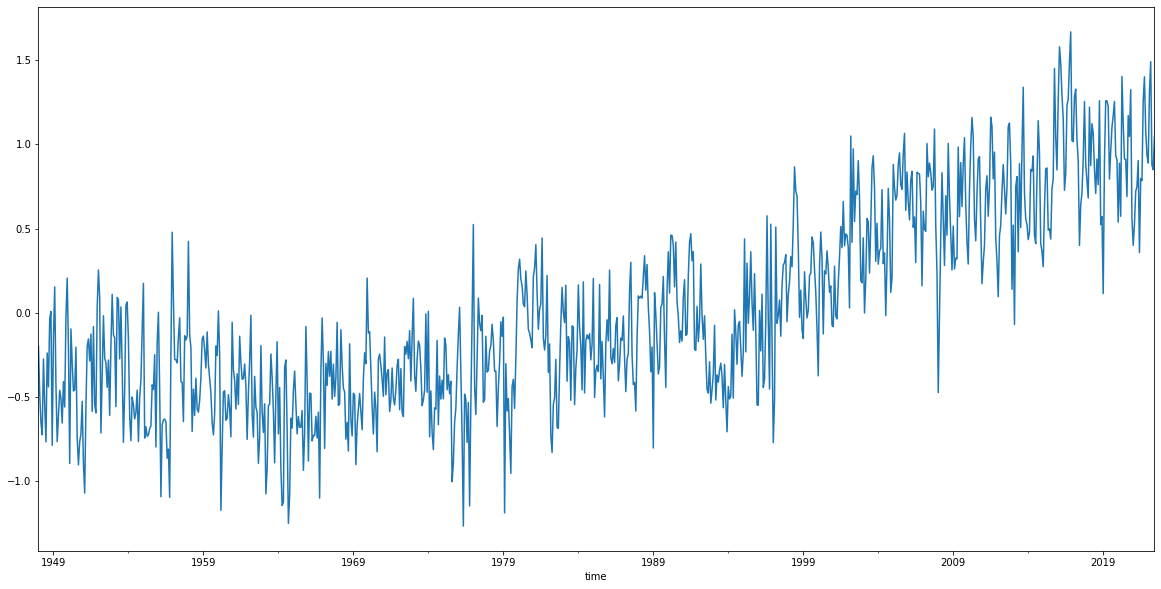

In [5]:
# mean temperatures for each month for all years
observations = air.groupby("time.month").mean("time")

# difference between actual temperatures and each month mean temperatures
anomalies = air.groupby("time.month") - observations

anomalies.mean({'lat', 'lon'}).to_dataframe()['air'].plot(figsize=(20,10))  

#### Calculate standardized monthly anomalies
You can create standardized anomalies where the difference between the observations and the climatological monthly mean is divided by the climatological standard deviation.

<AxesSubplot:xlabel='time'>

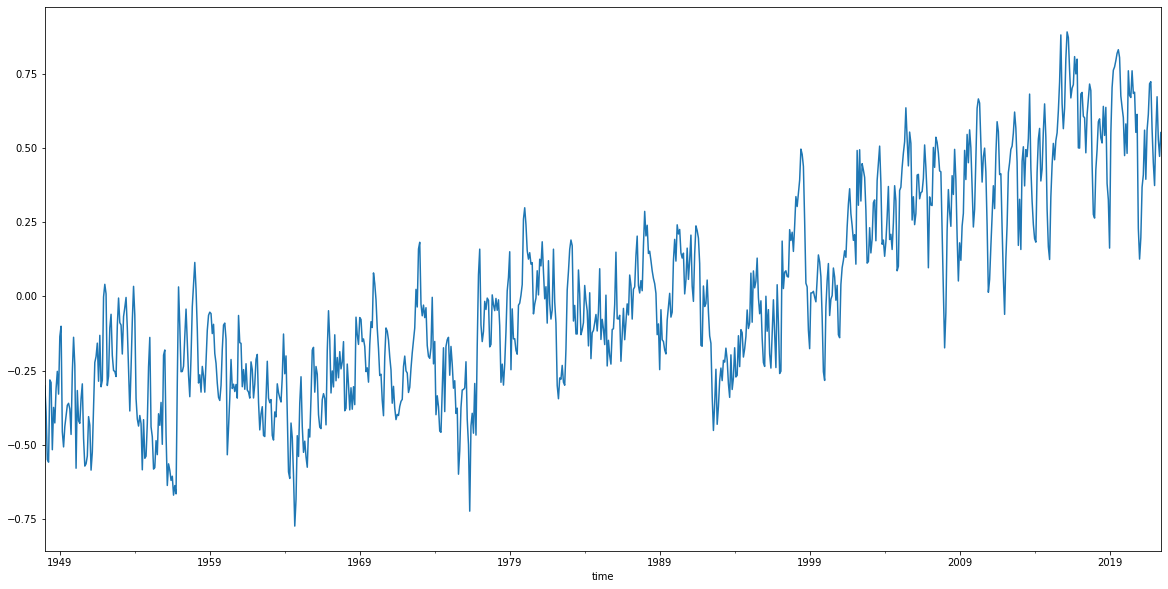

In [6]:
observations_mean = air.groupby("time.month").mean("time")
observations_std = air.groupby("time.month").std("time")

anomalies_std = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    air.groupby("time.month"),
    observations_mean,
    observations_std,
)

anomalies_std.mean({'lat', 'lon'}).to_dataframe()['air'].plot(figsize=(20,10))  

(882, 73, 144)


Text(0.5, 1.0, 'Mean Global Precipitation')

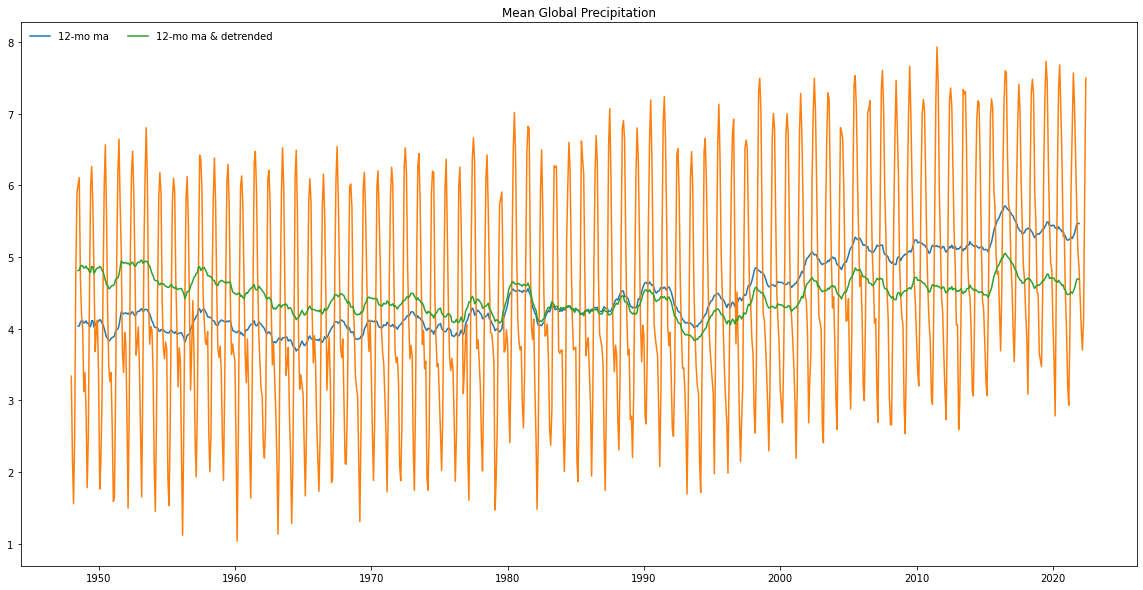

In [9]:
data = air.rolling(time= 12, center=True).mean()[6:-6,...] 
print(data.shape)

plt.figure(figsize=(20, 10))
plt.plot(data.time, data.mean(axis=(1,2)), label = '12-mo ma')
plt.plot(air.time, air.mean(axis=(1,2)))
mean = data.mean(axis=0)

"""Detrend data as it would influence the correlation"""
data = xr.DataArray(signal.detrend(data, axis=0), dims=data.dims, coords=data.coords) + mean
plt.plot(data.time, data.mean(axis=(1,2)), label = '12-mo ma & detrended')
plt.legend(loc = 'upper left', ncol = 3).draw_frame(False)
plt.title('Mean Global Precipitation')

In [22]:
air_sam = data.sel(lat=slice(15, -55), lon=slice(30+180, 85+180))
air_enb = data.sel(lat=slice(5, -5), lon=slice(120+180, 170+180))
air_mix = data.sel(lat=slice(15, -55), lon=slice(30+180, 170+180))

In [23]:
air_mix

<xarray.DataArray (time: 882, lat: 29, lon: 57)>
array([[[24.7649798 , 24.38714756, 24.25373245, ..., 28.58623527,
         29.07161387, 27.72077497],
        [25.10653246, 25.01057645, 25.03544077, ..., 27.45828646,
         27.23638156, 26.23887153],
        [25.54974458, 25.66077181, 25.58208649, ..., 26.7021857 ,
         25.64838609, 24.5057175 ],
        ...,
        [ 8.17532424,  8.16281884,  8.21177652, ...,  3.37422354,
          3.14605687,  2.93777305],
        [ 6.92973795,  6.75920192,  6.59339135, ...,  1.68475176,
          1.50970743,  1.39112065],
        [ 4.29175538,  4.19677091,  4.1992858 , ...,  0.37799557,
          0.23718201,  0.08682316]],

       [[24.75154822, 24.3670917 , 24.24039801, ..., 28.74553228,
         29.25857163, 27.86228296],
        [25.09727729, 25.00444671, 25.03787092, ..., 27.56035293,
         27.39165563, 26.37606572],
        [25.5329782 , 25.65367529, 25.58235616, ..., 26.68065054,
         25.69896274, 24.59216817],
...
        [ 7.75559968,  7.77035539,  7.83720459, ...,  3.71666616,
          3.57296885,  3.46501137],
        [ 6.380044  ,  6.21128942,  6.02903667, ...,  1.91237371,
          1.71133704,  1.59217624],
        [ 3.94971781,  3.8766164 ,  3.84039293, ...,  0.52242534,
          0.3457623 ,  0.16445527]],

       [[24.95116603, 24.57400865, 24.3570311 , ..., 28.71766132,
         30.01666077, 28.93766975],
        [25.30697563, 25.2274632 , 25.28181488, ..., 27.45537168,
         27.83657834, 27.17507907],
        [25.75535236, 25.81774382, 25.71718159, ..., 26.39306983,
         25.56064661, 24.65526527],
        ...,
        [ 7.70808081,  7.73523592,  7.81420475, ...,  3.74112432,
          3.60232983,  3.49100019],
        [ 6.34867773,  6.1937298 ,  6.02127209, ...,  1.93299746,
          1.7373783 ,  1.61521302],
        [ 3.93105378,  3.87679807,  3.85297841, ...,  0.52789756,
          0.35014979,  0.16244902]]])
Coordinates:
  * lat      (lat) float32 15.0 12.5 10.0 7.5 5.0 ... -47.5 -50.0 -52.5 -55.0
  * lon      (lon) float32 210.0 212.5 215.0 217.5 ... 342.5 345.0 347.5 350.0
  * time     (time) datetime64[ns] 1948-07-01 1948-08-01 ... 2021-12-01

In [24]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

In [25]:
air_global = data

In [10]:
ts1 = air_global[:, 34, 34] # Temperaturas da região (34,34) durante o tempo
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=ts1,y=air_enb, lagx=1)
cor

<xarray.DataArray (lat: 5, lon: 21)>
array([[0.31003054, 0.30924214, 0.1659861 , 0.02904857, 0.06341387,
        0.07579848, 0.11252347, 0.17046874, 0.2192217 , 0.2006747 ,
        0.19338677, 0.21556133, 0.19332093, 0.18207903, 0.13075487,
        0.08880781, 0.07005983, 0.04352615, 0.04427365, 0.03584551,
        0.18187251],
       [0.21259621, 0.26298892, 0.28906754, 0.17282817, 0.09573528,
        0.13096537, 0.16782607, 0.20507362, 0.26682257, 0.25165545,
        0.22180567, 0.22600114, 0.20572565, 0.19023956, 0.12163298,
        0.0541201 , 0.04970012, 0.05171669, 0.05685894, 0.0534929 ,
        0.08016478],
       [0.22400819, 0.24712023, 0.22883499, 0.1521976 , 0.12468239,
        0.23025846, 0.29978312, 0.27295628, 0.2876972 , 0.32457431,
        0.35264743, 0.33214974, 0.28861993, 0.23958533, 0.15509423,
        0.08249897, 0.05793363, 0.04624296, 0.06035966, 0.08781789,
        0.11264671],
       [0.30483728, 0.32235838, 0.20968294, 0.1195966 , 0.14154237,
        0.24296222, 0.30381201, 0.36869791, 0.39186456, 0.40770263,
        0.46644112, 0.45246036, 0.36306622, 0.25461941, 0.16687711,
        0.10153555, 0.0535485 , 0.02973835, 0.04504189, 0.07206118,
        0.12301285],
       [0.39911883, 0.36310511, 0.23591623, 0.14365551, 0.11362477,
        0.16182231, 0.23671583, 0.42211487, 0.51039447, 0.42807711,
        0.46995368, 0.4639393 , 0.39076195, 0.26707693, 0.18251033,
        0.12604323, 0.0748855 , 0.04067867, 0.04921557, 0.08660537,
        0.15335297]])
Coordinates:
  * lat      (lat) float32 5.0 2.5 0.0 -2.5 -5.0
  * lon      (lon) float32 300.0 302.5 305.0 307.5 ... 342.5 345.0 347.5 350.0

In [26]:
# Separando o timeslice desejado
air_sam = air_sam.sel(time=slice('2006-01-01T00:00:00.000000000', '2007-12-01T00:00:00.000000000'))
air_enb = air_enb.sel(time=slice('2006-01-01T00:00:00.000000000', '2007-12-01T00:00:00.000000000'))
air_global = air_global.sel(time=slice('2006-01-01T00:00:00.000000000', '2007-12-01T00:00:00.000000000'))
air_mix = air_mix.sel(time=slice('2006-01-01T00:00:00.000000000', '2007-12-01T00:00:00.000000000'))

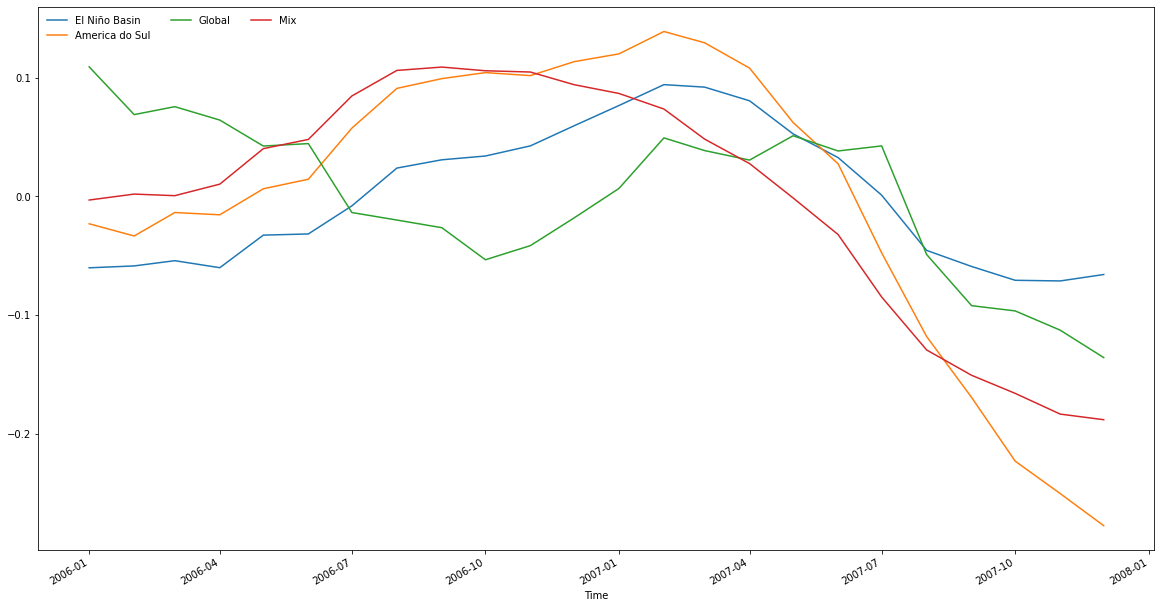

In [27]:
plt.figure(figsize=(20,10))
(air_enb.mean({'lat', 'lon'}) - air_enb.mean({'lat', 'lon'}).mean()).plot(label="El Niño Basin")
(air_sam.mean({'lat', 'lon'}) - air_sam.mean({'lat', 'lon'}).mean() ).plot(label="America do Sul")
(air_global.mean({'lat', 'lon'}) - air_global.mean({'lat', 'lon'}).mean() ).plot(label="Global")
(air_mix.mean({'lat', 'lon'}) - air_mix.mean({'lat', 'lon'}).mean() ).plot(label="Mix")
plt.legend(loc = 'upper left', ncol = 3).draw_frame(False)

In [28]:
# air_sam[time][lat][lon]
air_mix

<xarray.DataArray (time: 24, lat: 29, lon: 57)>
array([[[ 2.45315867e+01,  2.42424465e+01,  2.42482281e+01, ...,
          2.82031417e+01,  2.93235677e+01,  2.83476507e+01],
        [ 2.51194041e+01,  2.50980330e+01,  2.52296748e+01, ...,
          2.71581094e+01,  2.77989072e+01,  2.72948621e+01],
        [ 2.56739836e+01,  2.58428081e+01,  2.58117280e+01, ...,
          2.62623743e+01,  2.57358887e+01,  2.48912915e+01],
        ...,
        [ 7.98610369e+00,  7.95463755e+00,  7.93634406e+00, ...,
          3.47368794e+00,  3.25251273e+00,  3.07398935e+00],
        [ 6.62953589e+00,  6.39115351e+00,  6.16972965e+00, ...,
          1.76504979e+00,  1.57519080e+00,  1.42104127e+00],
        [ 4.13322911e+00,  3.97756425e+00,  3.89810033e+00, ...,
          1.12077630e-01, -1.01341761e-01, -3.39241145e-01]],

       [[ 2.45404660e+01,  2.42501083e+01,  2.42484155e+01, ...,
          2.82376498e+01,  2.93875422e+01,  2.84096706e+01],
        [ 2.51081602e+01,  2.50673620e+01,  2.51732365e+01, ...,
          2.72273008e+01,  2.78824370e+01,  2.73710363e+01],
        [ 2.56477288e+01,  2.58080805e+01,  2.57556520e+01, ...,
          2.62540380e+01,  2.57397963e+01,  2.48990042e+01],
...
        [ 7.76645093e+00,  7.80847919e+00,  7.84640827e+00, ...,
          3.32317204e+00,  3.16446044e+00,  3.03136915e+00],
        [ 6.46774978e+00,  6.28686619e+00,  6.10610390e+00, ...,
          1.54040400e+00,  1.38605996e+00,  1.26986834e+00],
        [ 3.72478586e+00,  3.67951186e+00,  3.72281694e+00, ...,
         -8.38467422e-02, -2.37166736e-01, -4.42718421e-01]],

       [[ 2.38249579e+01,  2.35333209e+01,  2.35001247e+01, ...,
          2.78507071e+01,  2.88571624e+01,  2.77450880e+01],
        [ 2.43789829e+01,  2.43290963e+01,  2.43954035e+01, ...,
          2.71279679e+01,  2.73397493e+01,  2.64696816e+01],
        [ 2.49363265e+01,  2.50787480e+01,  2.49825370e+01, ...,
          2.64790127e+01,  2.54921617e+01,  2.42635323e+01],
        ...,
        [ 7.79558522e+00,  7.83135774e+00,  7.86484685e+00, ...,
          3.28527865e+00,  3.11812289e+00,  2.97788161e+00],
        [ 6.48694731e+00,  6.28672829e+00,  6.09379602e+00, ...,
          1.48620326e+00,  1.32548931e+00,  1.21590308e+00],
        [ 3.72286962e+00,  3.66176509e+00,  3.69852161e+00, ...,
         -1.14624202e-01, -2.66394354e-01, -4.63447419e-01]]])
Coordinates:
  * lat      (lat) float32 15.0 12.5 10.0 7.5 5.0 ... -47.5 -50.0 -52.5 -55.0
  * lon      (lon) float32 210.0 212.5 215.0 217.5 ... 342.5 345.0 347.5 350.0
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2007-12-01

In [29]:
import itertools 
lat = [i/10 for i in range(150, -551, -25)]
lon = [i/10 for i in range(2100, 3501, 25)]

mix_network_attrs = {}
for i, grid_point in enumerate(itertools.product(lat, lon)):
    mix_network_attrs[grid_point] = {'lat': grid_point[0], 'lon': grid_point[1]}


In [35]:
# Estrutura da regiao escolhida
mix_net = nx.Graph()
mix_net.add_nodes_from(mix_network_attrs.keys())
nx.set_node_attributes(mix_net, mix_network_attrs)

In [36]:
# Estrutura El Nino
enb_lat = [i/10 for i in range(50, -75, -25)]
enb_lon = [i/10 for i in range(3000, 3525, 25)]

enb_network_attrs = {}
for i, grid_point in enumerate(itertools.product(enb_lat, enb_lon)):
    enb_network_attrs[grid_point] = {'lat': grid_point[0], 'lon': grid_point[1]}

enb_net = nx.Graph()
enb_net.add_nodes_from(enb_network_attrs.keys())
nx.set_node_attributes(enb_net, enb_network_attrs)

In [51]:
# time series do el nino de 2006-2007
for i, mix_node1 in enumerate(mix_net.nodes()):
    lat = mix_net.nodes[mix_node1]['lat']
    lon = mix_net.nodes[mix_node1]['lon']
    ts2 = air_mix.sel(lat=lat, lon=lon)

    for j, mix_node2 in enumerate(mix_net.nodes()):
        if j <= i:
            continue

        mix_lat = mix_net.nodes[mix_node2]['lat']
        mix_lon = mix_net.nodes[mix_node2]['lon']
        mix_ts2 = air_mix.sel(lat=mix_lat, lon=mix_lon)
        
        cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=mix_ts2, y=ts2)
        # print(cor)
        if (abs(cor) > 0.8 and abs(cor) != 1):
            mix_net.add_edge(mix_node1, mix_node2, weight=cor)